In [1]:
if !@isdefined(PACKAGES)
    using Pkg;
    Pkg.add("Arpack");
    Pkg.add("CSV");
    Pkg.add("DataFrames");
    Pkg.add("Plots");
    Pkg.add("LaTeXStrings");
    using CSV;
    using DataFrames;
    using LinearAlgebra;
    using Arpack;
    using Plots;
    using LaTeXStrings;
    PACKAGES = true;
end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
    Updating `~/.julia/environments/v1.8/Project.toml`
  [b964fa9f] + LaTeXStrings v1.3.0
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


true

In [2]:
function spin_state(num_spins, chain_configuration, spin_number)
    if spin_number > num_spins
         throw(DomainError(spin_number, "Spin number should be <= num_spins"))
    end
    spin_number -= 1 # start counting of bits from 1
    mask = 1 << spin_number
    state = chain_configuration & mask
    return state != 0 ? 1 : -1
end

spin_state (generic function with 1 method)

In [3]:
function inter_chain_contribution(num_spins, ch1, ch2)
    hij = 0
    for i in 1:num_spins
        hij += spin_state(num_spins, ch1, i)*spin_state(num_spins, ch2, i)
    end
    return hij
end

inter_chain_contribution (generic function with 1 method)

In [4]:
function chain_contribution(num_spins, chain_conf)
    hij = 0
    for i in 1:num_spins
        hij += (spin_state(num_spins, chain_conf, i)
        *spin_state(num_spins, chain_conf, i%num_spins + 1))
    end
    return hij
end

chain_contribution (generic function with 1 method)

In [5]:
function hamiltonian(n, ch1, ch2, jnn)
    hij = (
        0.5*jnn*chain_contribution(n, ch1)
        + 0.5*jnn*chain_contribution(n, ch2)
        + jnn*inter_chain_contribution(n, ch1, ch2)
    )
    return hij
end

hamiltonian (generic function with 1 method)

In [6]:
function tm_element(n, ch1, ch2, jnn, temp)
    return exp(-hamiltonian(n, ch1, ch2, jnn)/temp)
end

tm_element (generic function with 1 method)

In [7]:
function tm_n(n, temp)
    n_states = 2^n
    jnn = -1
    
    # fastest way to calculate a matrix in Julia is with a list-comprehension
    tm_block = [tm_element(n, ch1, ch2, jnn, temp) for ch1 = 1:n_states, ch2 = 1:n_states]
    
    return tm_block
end

tm_n (generic function with 1 method)

In [8]:
function corr_len(n_spins, temp)
    tm_block = tm_n(n_spins, temp)
    if n_spins > 2
        # Arnoldi iteration can't find the smallest eigenvalue (only the n_states-1 largest),
        # thus if n = 1, and n_states = 2 => the second eigenvalue won't be found
        # ref: https://en.wikipedia.org/wiki/Arnoldi_iteration#Finding_eigenvalues_with_the_Arnoldi_iteration
        eig_val, eig_vec = eigs(tm_block, nev=2); # first and second largest eigenvalues
        cln = 1.0/(log(eig_val[1]/abs(eig_val[2])))
    else
        # the built-in Julia method finds ALL eigenvalues (not just the k largest), 
        # but is slower than ARPACK (ok for 2x2 matrices)
        eig_val = sort(eigvals(tm_block), rev=true)
        cln = 1.0/(log(eig_val[1]/abs(eig_val[2])))
    end
    
    return cln
end

corr_len (generic function with 1 method)

In [9]:
corr_len(8, 2) # expected 38.09513540501129

38.095135405011604

In [10]:
function calculate_ratios(n_spins, temp)
    r = [(corr_len(i, temp)*(i+1))/(corr_len(i+1, temp)*i) for i = 2:n_spins-1]
    return r
end

calculate_ratios (generic function with 1 method)

In [11]:
function calculate_temp_range(; n_spins, temp0, tempinc, max_iter)
    column_names =  ["r$i$(i+1)" for i = 2:n_spins-1]
    prepend!(column_names, ["MaxSpins", "temp"])
    rows = DataFrame([Float64[] for i in 1:length(column_names)], column_names)
    for i in 0:max_iter
        t = temp0+tempinc*i
        ratios = calculate_ratios(n_spins, t)
        row = [n_spins, t]
        append!(row, ratios)
        rows = push!(rows, row)
    end
    return rows
end

calculate_temp_range (generic function with 1 method)

In [34]:
MAX_SPINS_CHAIN = 8;
TEMP0 = 0.500;
TEMP_INC = 0.006;
MAX_ITER = 500;

In [35]:
temp_range = calculate_temp_range(n_spins=MAX_SPINS_CHAIN, temp0=TEMP0, tempinc=TEMP_INC, max_iter=MAX_ITER)

Row,MaxSpins,temp,r23,r34,r45,r56,r67,r78
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,8.0,0.5,0.0275103,0.02447,0.0229559,0.0220524,0.0214606,0.0213483
2,8.0,0.506,0.0288504,0.0256637,0.0240774,0.0231311,0.0225016,0.0221675
3,8.0,0.512,0.0302225,0.0268861,0.025226,0.0242362,0.0235847,0.0231192
4,8.0,0.518,0.0316262,0.028137,0.0264017,0.0253678,0.0246847,0.0241017
5,8.0,0.524,0.0330612,0.0294161,0.027604,0.0265251,0.0258137,0.0252871
6,8.0,0.53,0.0345271,0.030723,0.0288329,0.0277083,0.0269655,0.0264181
7,8.0,0.536,0.0360235,0.0320575,0.0300881,0.0289171,0.0281453,0.0276487
8,8.0,0.542,0.03755,0.0334192,0.0313692,0.0301514,0.029348,0.0287925
9,8.0,0.548,0.0391064,0.034808,0.0326761,0.0314106,0.0305781,0.0299903


In [39]:
CSV.write("corr-len-output/corl-tmp-long_$(MAX_SPINS_CHAIN)_$(TEMP0)_$(TEMP_INC).dat", temp_range, delim="\t")

"corr-len-output/corl-tmp-long_8_0.5_0.006.dat"

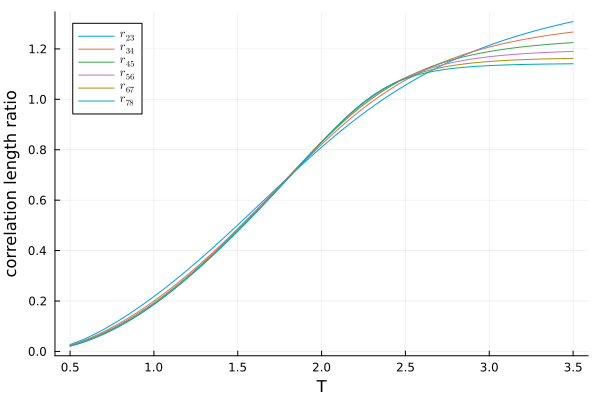

"/home/data/shared-data/transfer-matrix/corr-len-output/corl-tmp-long_8_0.5_0.006.png"

In [42]:
p = plot(dpi=600)
xlabel!(p, "T")
ylabel!(p, "correlation length ratio")
for i in 2:Int(temp_range.MaxSpins[1]-1)
    plot!(p, temp_range.temp, temp_range[!,"r$i$(i+1)"], label=latexstring("\$r_{$(i), $(i+1)}\$"))
end
display(p)
savefig(p, "corr-len-output/corl-tmp-long_$(MAX_SPINS_CHAIN)_$(TEMP0)_$(TEMP_INC).png") 